### 0. Prerequisites

In [55]:
#Modules used that need to be installed in the kernel
!pip install --upgrade python-youtube --quiet
!pip install git+https://github.com/openai/whisper.git --quiet
!pip install pytube --quiet
!pip install transformers --quiet

#Modules used that need to be imported
from pyyoutube import Client
from pytube import YouTube
import whisper
import csv
import pandas as pd
import isodate
import json
import os
import string
import nltk
import math
import matplotlib.pyplot as plt
from transformers import pipeline
import numpy as np
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import warnings

#Models and data that needs to be loaded/downloaded
warnings.filterwarnings("ignore", category=DeprecationWarning) # Ignore some deprecation warnings from upcoming cells
model = whisper.load_model("base")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


True

In [56]:
#Variables used to avoid some hard coded values
channelId = "UCBJycsmduvYEL83R_U4JriQ"
playlistId = "UU" + channelId[2:]
maxVideos = 20
wordsTableCount = 15
wordsGraphCount = 7
gridsVertical = 10
gridsHorizontal = 2
topicsCount = 5
topicsWordsCount = 10

### 1. Data Collection & Web Scraping

In [57]:
#Check if we already gathered the information we need from the channel or it's already given to us
if (not os.path.exists('/content/video_details.csv')):
  #Private information is kept in a separate file to avoid sharing it accidentally
  f = open('secrets.json')
  secrets = json.load(f)
  f.close()

  #Lists to store the information about the videos and most comments of each video (because of daily quota limits)
  videos_list = []
  comments_list = []

  #Get the information from the channel using a simpler API based on the Youtube Data API v3
  client = Client(api_key=secrets['apiKey'])

  #Get the latest 50 videos from the channel
  playlist_response = client.playlistItems.list(
      part="snippet",
      playlist_id=playlistId,
      maxResults=50,
      return_json = True
      )
  # Loop through all the videos in the playlist
  while True:
    # List of video IDs
    videos_id = []

    # Add the video IDs to the list
    for item in playlist_response['items']:
      videos_id += [item['snippet']['resourceId']['videoId']]

    # Get the information about the videos
    video_response = client.videos.list(
        part="snippet, contentDetails, statistics",
        video_id=videos_id,
        return_json = True
        )

    # Loop through all the videos
    for item in video_response['items']:
      # Check if the video is a short or a regular video
      if (isodate.parse_duration(item.get('contentDetails', 'PT0S').get('duration', 'PT0S')).days > 0 or isodate.parse_duration(item.get('contentDetails', 'PT0S').get('duration', 'PT0S0')).seconds > 60): # Youtube Shorts have a maximum duration of 60 seconds
        # Download the audio of the video
        yt = YouTube(f"https://www.youtube.com/watch?v={item['id']}")
        audio_stream = yt.streams.get_audio_only()
        default_filename = audio_stream.download("/content")

        # Transcribe the audio
        transcript = model.transcribe(default_filename)

        # Add only the some of the information to the list
        videos_list += [(
            item.get('snippet', '').get('channelTitle', ''),
            item.get('snippet', '').get('channelId', ''),
            item.get('snippet', '').get('title', ''),
            item.get('id', ''),
            item.get('snippet', '').get('publishedAt', ''),
            item.get('contentDetails', '').get('duration', ''),
            item.get('statistics', '').get('viewCount', ''),
            item.get('statistics', '').get('likeCount', ''),
            item.get('statistics', '').get('commentCount', ''),
            item.get('snippet', '').get('tags', ''),
            transcript['text']
            )]

        # Get the comments of the video
        comments_response = client.commentThreads.list(
          part="snippet,replies",
          maxResults=100,
          order="relevance",
          return_json = True,
          video_id=item['id']
        )

        # Loop through all the top level comments (and some of the replies) of the video
        while True:
          # Add the top level comments to the list
          for comment in comments_response['items']:
            comments_list += [(
                item.get('snippet', '').get('channelTitle', ''),
                item.get('snippet', '').get('channelId', ''),
                item.get('snippet', '').get('title', ''),
                item.get('id', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('snippet', '').get('authorDisplayName', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('snippet', '').get('authorChannelId', '').get('value', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('id', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('id', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('snippet', '').get('textOriginal', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('snippet', '').get('publishedAt', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('snippet', '').get('updatedAt', ''),
                comment.get('snippet', {}).get('topLevelComment', {}).get('snippet', {}).get('likeCount', 0)
                )]

            # Add some of the replies to the list
            for replies in comment.get('replies', {}).get('comments', []):
              comments_list += [(
                  item.get('snippet', '').get('channelTitle', ''),
                  item.get('snippet', '').get('channelId', ''),
                  item.get('snippet', '').get('title', ''),
                  item.get('id', ''),
                  replies.get('snippet', '').get('authorDisplayName', ''),
                  replies.get('snippet', '').get('authorChannelId', '').get('value', ''),
                  comment.get('snippet', '').get('topLevelComment', '').get('id', ''),
                  replies.get('id', ''),
                  replies.get('snippet', '').get('textOriginal', ''),
                  replies.get('snippet', '').get('publishedAt', ''),
                  replies.get('snippet', '').get('updatedAt', ''),
                  replies.get('snippet', 0).get('likeCount', 0)
                  )]

          # Stop if we ran out of top level comments
          if not comments_response.get('nextPageToken', ''):
            break
          # Get the next 'page' of top level comments
          else:
            comments_response = client.commentThreads.list(
              part="snippet,replies",
              maxResults=100,
              order="relevance",
              return_json = True,
              video_id=item['id'],
              page_token=comments_response['nextPageToken']
            )

        # Stop if we reached the maximum number of videos
        if (len(videos_list)>=maxVideos):
          break

    # Stop if we reached the maximum number of videos
    if (len(videos_list)>=maxVideos):
      break
    # Get the next 'page' of videos
    else:
      playlist_response = client.playlistItems.list(
          part="snippet",
          playlist_id=playlistId,
          maxResults=50,
          return_json = True,
          page_token=playlist_response['nextPageToken']
          )

  # Save the video information to a CSV file
  with open('video_details.csv', 'w', newline='') as out:
      csv_out=csv.writer(out)
      csv_out.writerow([
          'Channel Name',
          'Channel ID',
          'Video Title',
          'Video ID',
          'Date Published',
          'Video Length',
          'No. Views',
          'No. Likes',
          'No. Comments',
          'Tags',
          'Transcript'
          ])
      for row in videos_list:
          csv_out.writerow(row)

  # Save the comment information to a CSV file
  with open('video_comments.csv', 'w', newline='') as out:
      csv_out=csv.writer(out)
      csv_out.writerow([
          'Channel Name',
          'Channel ID',
          'Video Title',
          'Video ID',
          'Author Name',
          'Author ID',
          'Parent Comment ID',
          'Comment ID',
          'Text',
          'Date Published',
          'Date Updated',
          'No. Likes'
          ])
      for row in comments_list:
          csv_out.writerow(row)

In [58]:
#Load the information from the CSV files
video_df = pd.read_csv('/content/video_details.csv')
comment_df = pd.read_csv('/content/video_comments.csv')

In [59]:
# Display the information about the videos in a (prettier) table
video_df

,Channel Name,Channel ID,Video Title,Video ID,Date Published,Video Length,No. Views,No. Likes,No. Comments,Tags,Transcript
0,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,2024-06-12T15:56:11Z,PT16M33S,2105038,102368,7373,"['Tim Cook', 'Tim Cook Interview', 'Apple Inte...","Alright Tim, great to see you. Thanks for spe..."
1,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,WWDC 2024 Recap: Is Apple Intelligence Legit?,qkYoBNdcXBU,2024-06-11T07:28:19Z,PT18M23S,4985555,198283,11892,"['WWDC', 'WWDC 2024', 'Apple Intelligence', 'A...",So we just got done with possibly one of the ...
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,I Visited Apple's Secret iPhone Testing Labs!,8reaJG7z-is,2024-06-07T21:31:09Z,PT10M52S,2676804,119174,6225,NaN,So a couple days ago I dropped a Twitter thre...
3,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Sonos Ace Headphones: You Had One Job!,6_3cLlSlTKw,2024-06-03T14:57:33Z,PT11M23S,2322170,77884,4194,"['Sonos Ace', 'Sonos headphones', 'Sonos', 'MK...","Alright, so the world of high-end noise-cance..."
4,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Android 15 Hands-On: Top 5 Features!,kkX8_nbBqBQ,2024-05-28T21:40:15Z,PT11M26S,2852481,113474,6558,"['Android 15', 'Android 15 features', 'Android...","Hey, what's up? I'm Kebih Hd here. And I've g..."
5,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,I Gave A Commencement Speech!,a7ItChBrY8E,2024-05-23T19:41:23Z,PT8M58S,1210461,82421,3836,"['MKBHD', 'commencement', 'commencement speech...","Hey, what's up y'all, MKBHD here. A bit of a ..."
6,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,5 Weird iPad Pro (M4) Decisions,PHcDrXeyguM,2024-05-22T02:26:31Z,PT13M2S,3768446,121125,6010,"['iPad Pro', 'iPad Pro M4', 'iPad Pro review',...","Alright, so I've been using the new M4 iPad P..."
7,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,M4 iPad Pro Impressions: Well This is Awkward,-T0MGehwWvE,2024-05-08T02:06:33Z,PT12M51S,6079657,183542,12938,"['M4 iPad', 'M4 iPad Pro', 'iPad Pro', 'iPad P...","Okay, so Apple had a nice short little 30 min..."
8,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Google Pixel 8A Impressions: Just Get The 8!,B3szaVzQx0o,2024-05-07T16:18:33Z,PT7M23S,2434787,83368,4546,"['Pixel 8A', 'Pixel 8a', 'Pixel 8A impressions...",Alright so there is just one thing that's sta...
9,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Rabbit R1: Barely Reviewable,ddTV12hErTc,2024-04-30T00:21:20Z,PT19M53S,7771745,232750,21869,"['Rabbit R1', 'Rabbit vs', 'Rabbit R1 vs', 'Hu...",So this is the Rabbit R1 and it's another AI ...


In [60]:
# Display the information about the comments in a (prettier) table
comment_df

,Channel Name,Channel ID,Video Title,Video ID,Author Name,Author ID,Parent Comment ID,Comment ID,Text,Date Published,Date Updated,No. Likes
0,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@JOELLZE,UCgFuet1BNypqzyKt_HppOdg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg,Mentioning ‘Ergonomics’ and ‘Magic Mouse’ in t...,2024-06-12T16:01:58Z,2024-06-12T16:01:58Z,30367
1,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@awdadwadwad1723,UC-k2Bv11O8vSB2cp2Z0vPgg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg.A4aI05D0prbA4aIsDMpkWd,I literally loled at that moment,2024-06-12T16:09:29Z,2024-06-12T16:09:29Z,1213
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@daswasesheutegibt,UCMGmT09jCXicTVwjAM5YdXw,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg.A4aI05D0prbA4aIyVyBXNd,He can’t be serious?,2024-06-12T16:10:21Z,2024-06-12T16:10:21Z,671
3,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@DomTheBom-ru6ib,UCYpvRAMhU2TRe2YEkbTozhA,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg.A4aI05D0prbA4aJTmLjhHx,Was thinking the same thing lmao,2024-06-12T16:14:45Z,2024-06-12T16:14:45Z,229
4,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@Zagoorland,UCXn-BSSWoCmdbTYT8QlluVg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg.A4aI05D0prbA4aJU0gLtlc,Right?? 😅😅😅,2024-06-12T16:14:47Z,2024-06-12T16:14:47Z,86
...,...,...,...,...,...,...,...,...,...,...,...,...
32135,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@rugrust08,UCmrdz9oRBu2OaV8K04_Oacw,Ugy8vXl8WRIC3I1__Z54AaABAg,Ugy8vXl8WRIC3I1__Z54AaABAg,Samsung galaxy s9 is poop 💩 phone ever I am us...,2024-06-04T08:06:47Z,2024-06-04T08:06:47Z,1
32136,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@tatsugiri1,UC-7M5My6wsVl488zYk_L-8Q,Ugy5PiuR3gNzGF9bT-B4AaABAg,Ugy5PiuR3gNzGF9bT-B4AaABAg,s20 is the ugliest galaxy ever 😭😭,2024-03-31T11:53:14Z,2024-03-31T11:53:14Z,1
32137,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@chrisjohn3992,UCNa2vie_znRCiiQ9if6zrIg,Ugy-oJIJHhRmSLNU9Qx4AaABAg,Ugy-oJIJHhRmSLNU9Qx4AaABAg,I own the worse Samsung Galaxy ever..s20fe,2024-03-30T10:58:38Z,2024-03-30T10:58:38Z,0
32138,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@Daniel-hy7th,UCY12zmqaofI2PxyCS1wXi1Q,UgxLc6Cys37kt77CuZ54AaABAg,UgxLc6Cys37kt77CuZ54AaABAg,All S20FE users gather here >>>>>>>>>>>>>,2024-03-21T12:40:25Z,2024-03-21T12:40:25Z,0


### 2. Data Cleaning & Preprocessing

In [61]:
# Characters allowed in the text
allowed_video_chars = string.ascii_letters + string.digits + string.whitespace
allowed_comment_chars = string.ascii_letters + string.digits + string.whitespace + ':'

# New dataframes to store the cleaned video data and get rid of the rows with missing values (except for missing tags, which are not mandatory)
clean_video_df = video_df.copy().dropna(subset=[
    'Channel Name',
    'Channel ID',
    'Video Title',
    'Video ID',
    'Date Published',
    'Video Length',
    'No. Views',
    'No. Likes',
    'No. Comments',
    'Transcript'
    ])

# Make sure the data types are correct
clean_video_df = clean_video_df.astype({
    'Channel Name': 'str',
    'Channel ID': 'str',
    'Video Title': 'str',
    'Video ID': 'str',
    'Date Published': 'str',
    'Video Length': 'str',
    'No. Views': 'int64',
    'No. Likes': 'int64',
    'No. Comments': 'int64',
    'Tags': 'str',
    'Transcript': 'str'
    })

# Transform the more "complex" data to a more usable format
clean_video_df['Date Published'] = clean_video_df['Date Published'].map(lambda x: isodate.parse_datetime(x))
clean_video_df['Video Length'] = clean_video_df['Video Length'].map(lambda x: isodate.parse_duration(x))
clean_video_df['Tags'] = clean_video_df['Tags'].map(lambda x: [y.strip('\'\"') for y in x.strip('][').split(', ')])

# Transform the transcript to a list of sentences and then explode the dataframe to have one clean sentence per row
clean_video_df['Transcript'] = clean_video_df['Transcript'].transform(lambda x: nltk.sent_tokenize(x))
clean_video_df = clean_video_df.explode('Transcript').reset_index(drop=True).rename(columns={'Transcript': 'Sentence'})
clean_video_df['Sentence'] = clean_video_df['Sentence'].map(lambda x: ''.join(c for c in x if c in allowed_video_chars))

# Split the sentences into list of words and explode the dataframe to have one word per row
clean_video_df['Word'] = clean_video_df['Sentence'].str.lower().str.split()
clean_video_df = clean_video_df.explode('Word').reset_index(drop=True)

# Remove the rows containing stopwords from the dataframe
clean_video_df = clean_video_df[~clean_video_df['Word'].isin(nltk.corpus.stopwords.words('english'))].reset_index(drop=True)


# New dataframes to store the cleaned comment data and get rid of the rows with any missing values
clean_comment_df = comment_df.copy().dropna()

# Make sure the data types are correct
clean_comment_df = clean_comment_df.astype({
    'Channel Name': 'str',
    'Channel ID': 'str',
    'Video Title': 'str',
    'Video ID': 'str',
    'Author Name': 'str',
    'Author ID': 'str',
    'Parent Comment ID': 'str',
    'Comment ID': 'str',
    'Text': 'str',
    'Date Published': 'str',
    'Date Updated': 'str',
    'No. Likes': 'int64'
    })

# Transform the more "complex" data to a more usable format
clean_comment_df['Date Published'] = clean_comment_df['Date Published'].map(lambda x: isodate.parse_datetime(x))
clean_comment_df['Date Updated'] = clean_comment_df['Date Updated'].map(lambda x: isodate.parse_datetime(x))

# Clean the text of the comments
clean_comment_df['Text'] = clean_comment_df['Text'].map(lambda x: ''.join(c for c in x if c in allowed_comment_chars))

# Split the comments into list of words and explode the dataframe to have one word per row
clean_comment_df['Word'] = clean_comment_df['Text'].str.lower().str.split()
clean_comment_df = clean_comment_df.explode('Word').reset_index(drop=True)

# Remove the rows containing stopwords from the dataframe
clean_comment_df = clean_comment_df[~clean_comment_df['Word'].isin(nltk.corpus.stopwords.words('english'))].reset_index(drop=True)

In [62]:
# Display the cleaned video data in a (prettier) table
clean_video_df

,Channel Name,Channel ID,Video Title,Video ID,Date Published,Video Length,No. Views,No. Likes,No. Comments,Tags,Sentence,Word
0,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,2024-06-12 15:56:11+00:00,0 days 00:16:33,2105038,102368,7373,"[Tim Cook, Tim Cook Interview, Apple Intellige...",Alright Tim great to see you,alright
1,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,2024-06-12 15:56:11+00:00,0 days 00:16:33,2105038,102368,7373,"[Tim Cook, Tim Cook Interview, Apple Intellige...",Alright Tim great to see you,tim
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,2024-06-12 15:56:11+00:00,0 days 00:16:33,2105038,102368,7373,"[Tim Cook, Tim Cook Interview, Apple Intellige...",Alright Tim great to see you,great
3,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,2024-06-12 15:56:11+00:00,0 days 00:16:33,2105038,102368,7373,"[Tim Cook, Tim Cook Interview, Apple Intellige...",Alright Tim great to see you,see
4,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,2024-06-12 15:56:11+00:00,0 days 00:16:33,2105038,102368,7373,"[Tim Cook, Tim Cook Interview, Apple Intellige...",Thanks for spending the time,thanks
...,...,...,...,...,...,...,...,...,...,...,...,...
28975,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,2024-03-02 01:23:30+00:00,0 days 00:43:49,3643687,123594,10923,"[every Galaxy S, Galaxy S, mkbhd, MKBHD, Every...",Anyway with S6 they also tried a little thing ...,one
28976,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,2024-03-02 01:23:30+00:00,0 days 00:43:49,3643687,123594,10923,"[every Galaxy S, Galaxy S, mkbhd, MKBHD, Every...",Anyway with S6 they also tried a little thing ...,peace
28977,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,2024-03-02 01:23:30+00:00,0 days 00:43:49,3643687,123594,10923,"[every Galaxy S, Galaxy S, mkbhd, MKBHD, Every...",Anyway with S6 they also tried a little thing ...,two
28978,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,2024-03-02 01:23:30+00:00,0 days 00:43:49,3643687,123594,10923,"[every Galaxy S, Galaxy S, mkbhd, MKBHD, Every...",Anyway with S6 they also tried a little thing ...,gigs


In [63]:
# Display the cleaned comment data in a (prettier) table
clean_comment_df

,Channel Name,Channel ID,Video Title,Video ID,Author Name,Author ID,Parent Comment ID,Comment ID,Text,Date Published,Date Updated,No. Likes,Word
0,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@JOELLZE,UCgFuet1BNypqzyKt_HppOdg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg,Mentioning Ergonomics and Magic Mouse in the s...,2024-06-12 16:01:58+00:00,2024-06-12 16:01:58+00:00,30367,mentioning
1,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@JOELLZE,UCgFuet1BNypqzyKt_HppOdg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg,Mentioning Ergonomics and Magic Mouse in the s...,2024-06-12 16:01:58+00:00,2024-06-12 16:01:58+00:00,30367,ergonomics
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@JOELLZE,UCgFuet1BNypqzyKt_HppOdg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg,Mentioning Ergonomics and Magic Mouse in the s...,2024-06-12 16:01:58+00:00,2024-06-12 16:01:58+00:00,30367,magic
3,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@JOELLZE,UCgFuet1BNypqzyKt_HppOdg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg,Mentioning Ergonomics and Magic Mouse in the s...,2024-06-12 16:01:58+00:00,2024-06-12 16:01:58+00:00,30367,mouse
4,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@JOELLZE,UCgFuet1BNypqzyKt_HppOdg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg,Mentioning Ergonomics and Magic Mouse in the s...,2024-06-12 16:01:58+00:00,2024-06-12 16:01:58+00:00,30367,sentence
...,...,...,...,...,...,...,...,...,...,...,...,...,...
422997,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@Daniel-hy7th,UCY12zmqaofI2PxyCS1wXi1Q,UgxLc6Cys37kt77CuZ54AaABAg,UgxLc6Cys37kt77CuZ54AaABAg,All S20FE users gather here,2024-03-21 12:40:25+00:00,2024-03-21 12:40:25+00:00,0,gather
422998,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@NoapteaMintii,UCvSt0WhKPmY1uxuKxlHuUvg,Ugwy10QACVWbK2NNvs54AaABAg,Ugwy10QACVWbK2NNvs54AaABAg,Galaxy S10 is by far the uglyest,2024-05-07 13:25:07+00:00,2024-05-07 13:25:07+00:00,0,galaxy
422999,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@NoapteaMintii,UCvSt0WhKPmY1uxuKxlHuUvg,Ugwy10QACVWbK2NNvs54AaABAg,Ugwy10QACVWbK2NNvs54AaABAg,Galaxy S10 is by far the uglyest,2024-05-07 13:25:07+00:00,2024-05-07 13:25:07+00:00,0,s10
423000,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@NoapteaMintii,UCvSt0WhKPmY1uxuKxlHuUvg,Ugwy10QACVWbK2NNvs54AaABAg,Ugwy10QACVWbK2NNvs54AaABAg,Galaxy S10 is by far the uglyest,2024-05-07 13:25:07+00:00,2024-05-07 13:25:07+00:00,0,far


### 3. TF-IDF

In [10]:
# New dataframes to store the number of times each word appears in the each video
tf_idf_video_df = clean_video_df.value_counts([
    'Channel Name',
    'Channel ID',
    'Video Title',
    'Video ID',
    'Date Published',
    'Word'
    ]).reset_index(name='Video Individual Word Count')

# Add to each row the total number of words in the associated video
tf_idf_video_df = tf_idf_video_df.merge(tf_idf_video_df[[
    'Video ID',
    'Video Individual Word Count'
    ]].groupby('Video ID').sum().reset_index().rename(columns={'Video Individual Word Count': 'Video Total Word Count'}), on='Video ID')

# Calculate the TF, IDF and TF-IDF values for each word in the video
tf_idf_video_df = tf_idf_video_df.assign(TF = lambda x: x['Video Individual Word Count']/x['Video Total Word Count'])
tf_idf_video_df = tf_idf_video_df.merge((len(tf_idf_video_df.value_counts('Video ID'))/tf_idf_video_df.value_counts(['Word'])).map(math.log).reset_index(name='IDF'), how='left', on='Word')
tf_idf_video_df = tf_idf_video_df.assign(TF_IDF = lambda x: x['TF']*x['IDF'])


# New dataframes to store the number of times each word appears in the comments section of each video
tf_idf_comment_df = clean_comment_df.value_counts([
    'Channel Name',
    'Channel ID',
    'Video Title',
    'Video ID',
    'Word'
    ]).reset_index(name='Video Individual Word Count')

# Add to each row the total number of words in the associated comments section of the video
tf_idf_comment_df = tf_idf_comment_df.merge(tf_idf_comment_df[[
    'Video ID',
    'Video Individual Word Count'
    ]].groupby('Video ID').sum().reset_index().rename(columns={'Video Individual Word Count': 'Video Total Word Count'}), on='Video ID')

# Calculate the TF, IDF and TF-IDF values for each word in the comments section of the video
tf_idf_comment_df = tf_idf_comment_df.assign(TF = lambda x: x['Video Individual Word Count']/x['Video Total Word Count'])
tf_idf_comment_df = tf_idf_comment_df.merge((len(tf_idf_comment_df.value_counts('Video ID'))/tf_idf_comment_df.value_counts(['Word'])).map(math.log).reset_index(name='IDF'), how='left', on='Word')
tf_idf_comment_df = tf_idf_comment_df.assign(TF_IDF = lambda x: x['TF']*x['IDF'])

In [11]:
# List of video IDs sorted by date (from newest to oldest)
chronological_video_id_list = tf_idf_video_df[['Video ID', 'Date Published']].sort_values('Date Published', ascending=False).drop_duplicates()['Video ID'].to_list()

In [12]:
# Temporary list to store the top x rows having the highest TF-IDF values for each video
temp_list = []

# Get the top x rows having the highest TF-IDF values for each video
for id in chronological_video_id_list:
  temp_list += tf_idf_video_df[tf_idf_video_df['Video ID'] == id].sort_values('TF_IDF', ascending=False).head(wordsTableCount).values.tolist()

# Set the display options to show all the rows
pd.set_option('display.max_rows', None)

# Display the top x words for each video in a (prettier) table
pd.DataFrame(temp_list, columns=tf_idf_video_df.columns.values.tolist()).set_index(['Channel Name', 'Channel ID', 'Video Title', 'Video ID', 'Date Published', 'Word'])

Video Individual Word Count  \
Channel Name     Channel ID               Video Title                                     Video ID    Date Published            Word                                         
Marques Brownlee UCBJycsmduvYEL83R_U4JriQ Talking Tech and AI with Tim Cook!              pMX2cQdPubk 2024-06-12 15:56:11+00:00 ai                                      22   
                                                                                                                                ranking                                  5   
                                                                                                                                ceo                                      5   
                                                                                                                                privacy                                  6   
                                                                                                                                intelligence                             5   
                                                                                                                                generative                               6   
                                                                                                                                changed                                  5   
                                                                                                                                detection                                4   
                                                                                                                                compute                                  4   
                                                                                                                                chatter                                  3   
                                                                                                                                cloud                                    5   
                                                                                                                                thank                                    4   
                                                                                                                                vision                                   6   
                                                                                                                                mouse                                    3   
                                                                                                                                developer                                3   
                                          WWDC 2024 Recap: Is Apple Intelligence Legit?   qkYoBNdcXBU 2024-06-11 07:28:19+00:00 intelligence                             8   
                                                                                                                                icons                                    6   
                                                                                                                                calculator                               6   
                                                                                                                                apple                                   30   
                                                                                                                                ai                                      20   
                                                                                                                                mac                                      7   
                                                                                                                                ipad         

In [13]:
# Reset the maximum number of rows displayed in a dataframe table to the default value
pd.set_option('display.max_rows', 60)

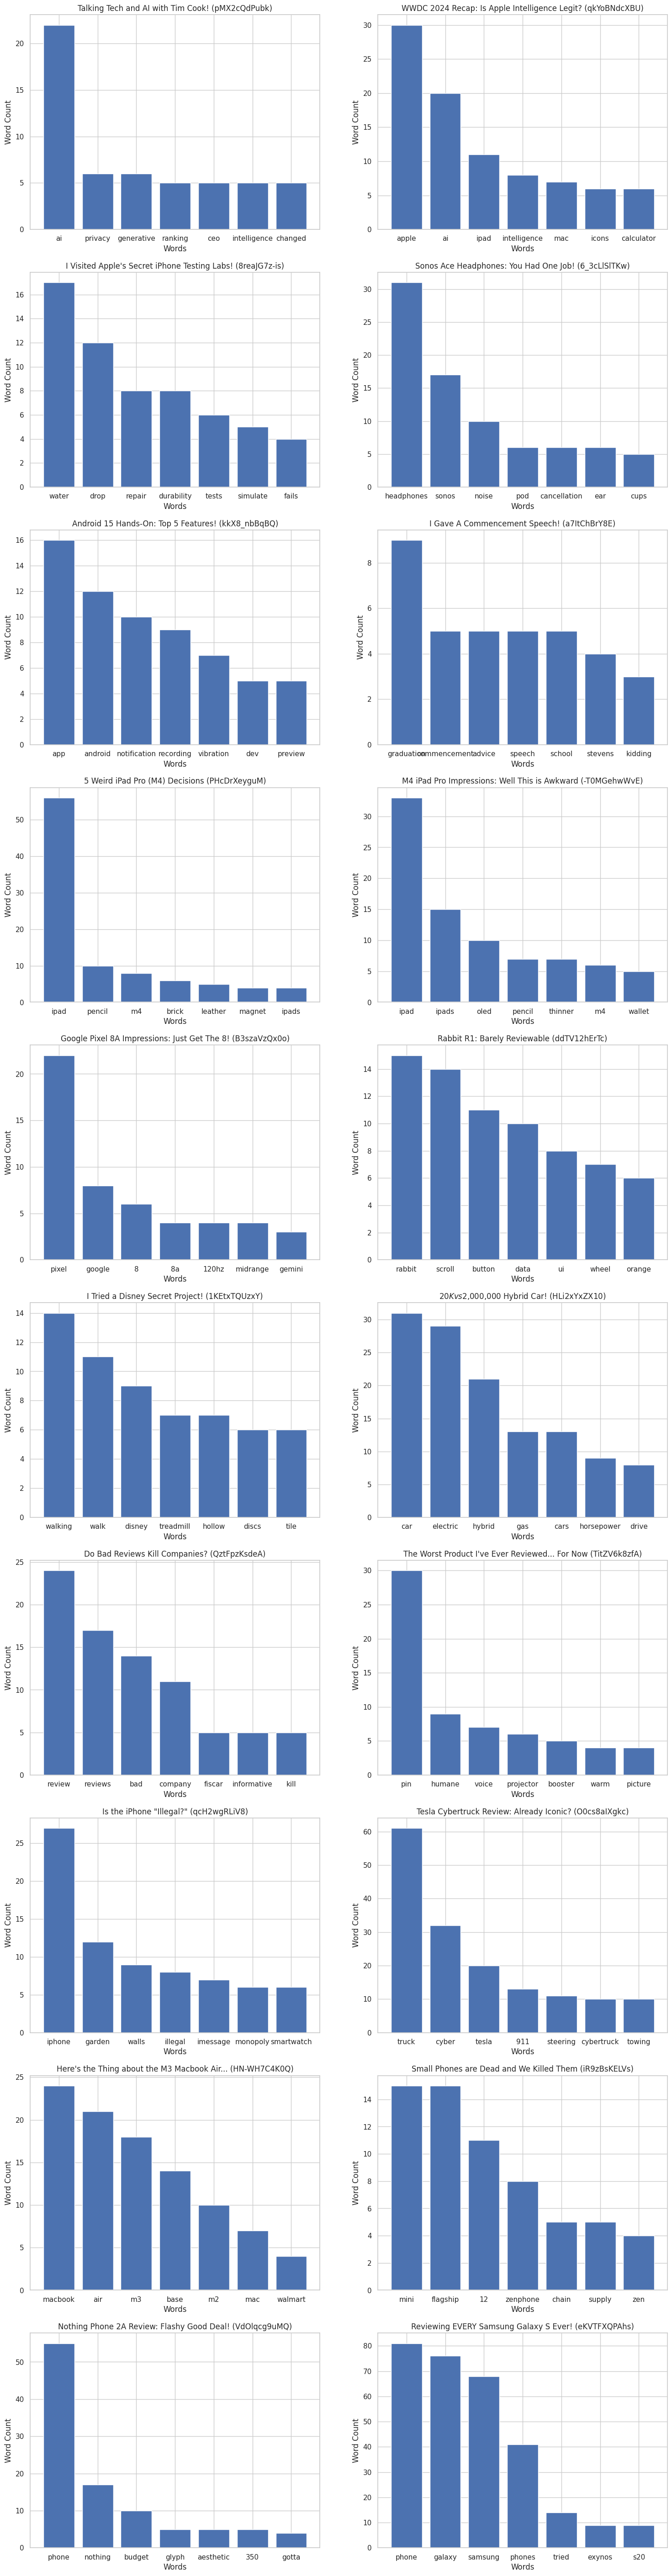

In [53]:
# Temporary list to store the top words for each video
temp_list = []

# Loop through the chronological list of video IDs and store the video ID and title in the temporary list
for id in chronological_video_id_list:
  temp_list += [[id, tf_idf_video_df[tf_idf_video_df['Video ID'] == id]['Video Title'].values[0]]]

# List of lists to store the top k words for each video, their TF-IDF values, the video title and the video ID
video_list = []

# Loop through the temporary list and store the video ID, title, top k words and their TF-IDF values in the video list
for video in temp_list:
  temp_df = tf_idf_video_df[tf_idf_video_df['Video ID'] == video[0]][['Word', 'Video Individual Word Count', 'TF_IDF']].sort_values('TF_IDF', ascending=False).head(wordsGraphCount).sort_values('Video Individual Word Count', ascending=False)
  video += [temp_df['Word'].to_list(), temp_df['Video Individual Word Count'].to_list()]
  video_list += [video]

# Create a figure with subplots to display the top k words for each video in a bar graph
figure, axis = plt.subplots(gridsVertical, gridsHorizontal)
figure.set_figwidth(18)
figure.set_figheight(72)

# Loop through the video list and create a bar graph for each video
for i in range(gridsVertical):
  for j in range(gridsHorizontal):
    axis[i, j].bar(video_list[i*gridsHorizontal+j][2], video_list[i*gridsHorizontal+j][3])
    axis[i, j].set_title(f'{video_list[i*gridsHorizontal+j][1]} ({video_list[i*gridsHorizontal+j][0]})')
    axis[i, j].set_xlabel('Words')
    axis[i, j].set_ylabel('Word Count')

In [15]:
# Temporary list to store the top x rows having the highest TF-IDF values for each video
temp_list = []

# Get the top x rows having the highest TF-IDF values for each video
for id in chronological_video_id_list:
  temp_list += tf_idf_comment_df[tf_idf_comment_df['Video ID'] == id].sort_values('TF_IDF', ascending=False).head(wordsTableCount).values.tolist()

# Set the display options to show all the rows
pd.set_option('display.max_rows', None)

# Display the top x words for each video in a (prettier) table
pd.DataFrame(temp_list, columns=tf_idf_comment_df.columns.values.tolist()).set_index(['Channel Name', 'Channel ID', 'Video Title', 'Video ID', 'Word'])

Video Individual Word Count  \
Channel Name     Channel ID               Video Title                                     Video ID    Word                                           
Marques Brownlee UCBJycsmduvYEL83R_U4JriQ Talking Tech and AI with Tim Cook!              pMX2cQdPubk tim                                      419   
                                                                                                      mouse                                    402   
                                                                                                      ergonomics                               120   
                                                                                                      interview                                137   
                                                                                                      cook                                     141   
                                                                                                      ranking                                   34   
                                                                                                      tims                                      29   
                                                                                                      tim:                                      21   
                                                                                                      magic                                    358   
                                                                                                      interviews                                25   
                                                                                                      ergonomic                                 25   
                                                                                                      interviewing                              10   
                                                                                                      rank                                      15   
                                                                                                      interviewer                                9   
                                                                                                      ceo                                       51   
                                          WWDC 2024 Recap: Is Apple Intelligence Legit?   qkYoBNdcXBU awt37x                                    51   
                                                                                                      calculator                               149   
                                                                                                      math                                      83   
                                                                                                      intelligence                              94   
                                                                                                      tinder                                    21   
                                                                                                      siri                                      74   
                                                                                                      android                                  186   
                                                                                                      hotel                                     20   
                                                                                                      icons                                     35   
                                                                                                      equations                                 17   
                                                                     

In [16]:
# Reset the maximum number of rows displayed in a dataframe table to the default value
pd.set_option('display.max_rows', 60)

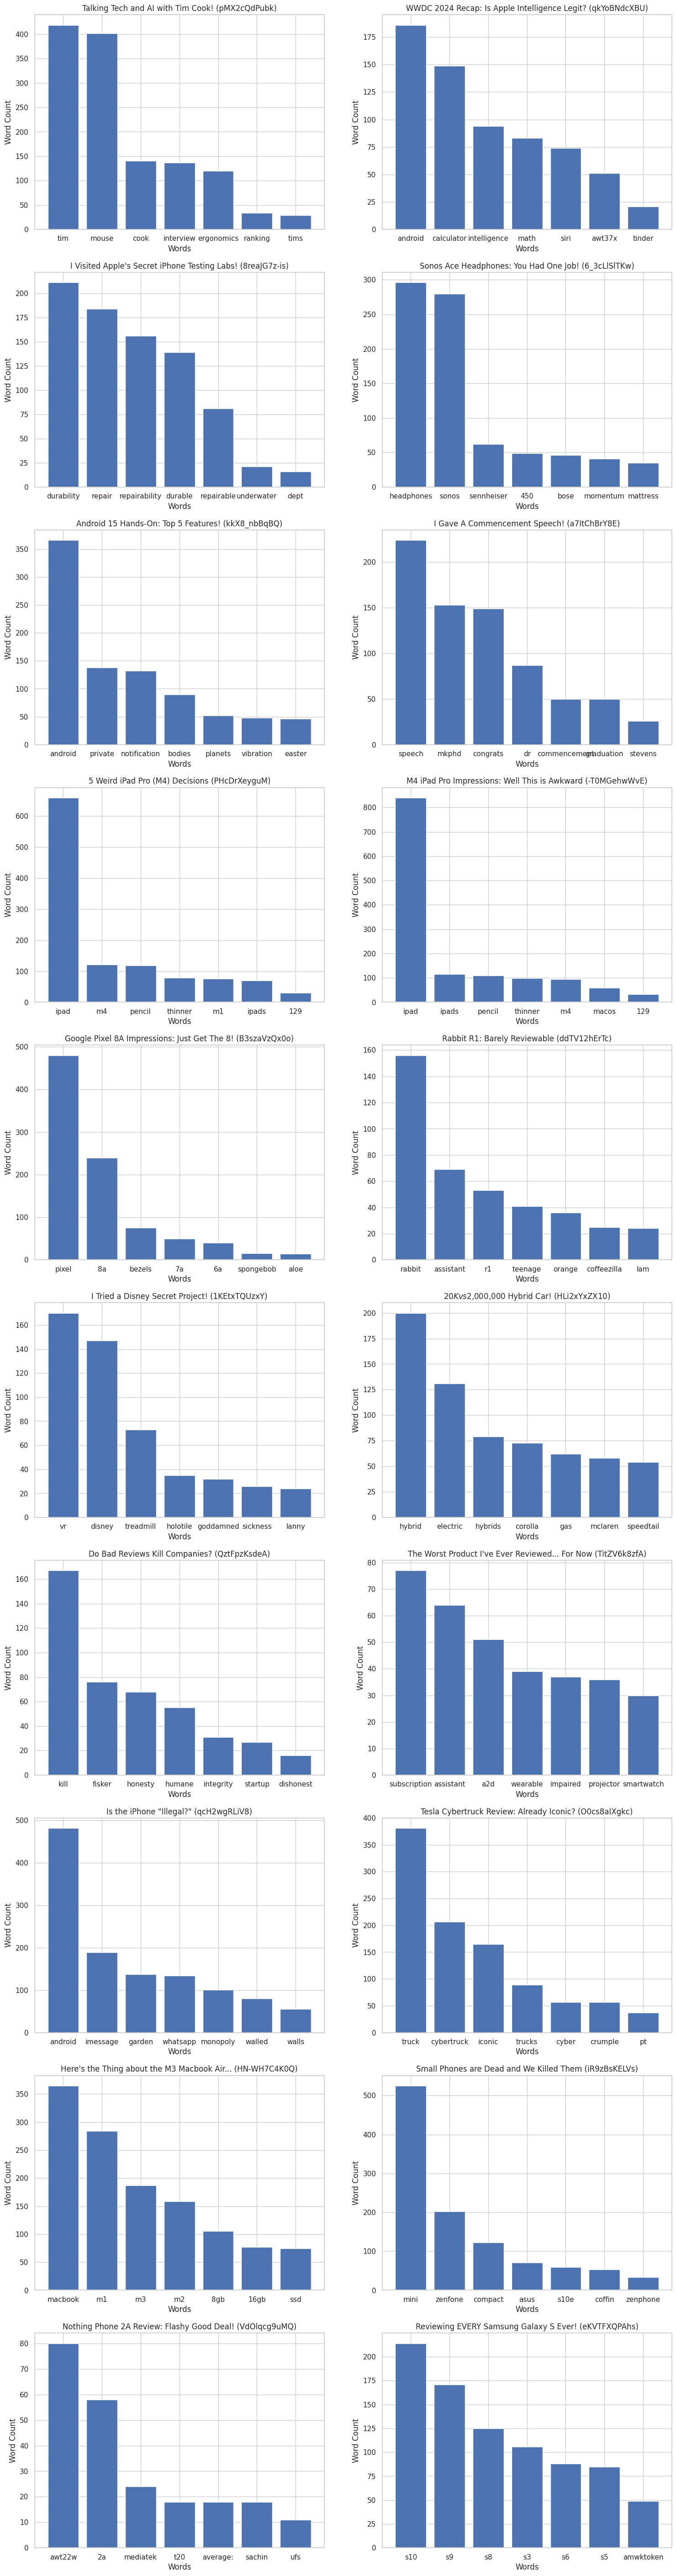

In [54]:
# Temporary list to store the top words for each video
temp_list = []

# Loop through the chronological list of video IDs and store the video ID and title in the temporary list
for id in chronological_video_id_list:
  temp_list += [[id, tf_idf_video_df[tf_idf_video_df['Video ID'] == id]['Video Title'].values[0]]]

# List of lists to store the top k words for each video, their TF-IDF values, the video title and the video ID
comment_list = []

# Loop through the temporary list and store the video ID, title, top k words and their TF-IDF values in the video list
for video in temp_list:
  temp_df = tf_idf_comment_df[tf_idf_comment_df['Video ID'] == video[0]][['Word', 'Video Individual Word Count', 'TF_IDF']].sort_values('TF_IDF', ascending=False).head(wordsGraphCount).sort_values('Video Individual Word Count', ascending=False)
  video += [temp_df['Word'].to_list(), temp_df['Video Individual Word Count'].to_list()]
  comment_list += [video]

# Create a figure with subplots to display the top k words for each video in a bar graph
figure, axis = plt.subplots(gridsVertical, gridsHorizontal)
figure.set_figwidth(18)
figure.set_figheight(72)

# Loop through the video list and create a bar graph for each video
for i in range(gridsVertical):
  for j in range(gridsHorizontal):
    axis[i, j].bar(comment_list[i*gridsHorizontal+j][2], comment_list[i*gridsHorizontal+j][3])
    axis[i, j].set_title(f'{comment_list[i*gridsHorizontal+j][1]} ({comment_list[i*gridsHorizontal+j][0]})')
    axis[i, j].set_xlabel('Words')
    axis[i, j].set_ylabel('Word Count')

### 4. Topic Modelling

In [64]:
lemmatizer = WordNetLemmatizer()
# List of video IDs sorted by date (from newest to oldest)
chronological_video_id_list = clean_video_df[['Video ID', 'Date Published']].drop_duplicates().sort_values('Date Published', ascending=False)['Video ID'].to_list()

preprocessed_videos = []
for id in chronological_video_id_list:
  preprocessed_videos += [' '.join(clean_video_df[clean_video_df['Video ID'] == id]['Word'].to_list())]

vectorizer = CountVectorizer(max_df=0.75, min_df=2, stop_words='english', ngram_range=(1,3))
term_document_matrix = vectorizer.fit_transform(preprocessed_videos)

# Apply LDA
lda = LatentDirichletAllocation(n_components=topicsCount, random_state=42)
lda.fit(term_document_matrix)

# List of keywords for each topic
topic_keywords_list = []

# store top words for each topic
for topic_idx, topic in enumerate(lda.components_):
  keywords = " ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-topicsWordsCount - 1:-1]])
  topic_keywords_list += [keywords]

for index, topic_keywords in enumerate(topic_keywords_list):
  print(f"Topic #{index + 1}: {topic_keywords}")

Topic #1: phone galaxy screen phones samsung iphone apple ai battery camera
Topic #2: ipad battery pro car electric ipad pro apple ipads pencil display
Topic #3: truck cyber cyber truck tesla water video car drop iphone looks
Topic #4: headphones button rabbit walking moving scroll walk mode data app
Topic #5: pin phone ai review apple product air bad macbook humane


In [65]:
document_topics = lda.transform(term_document_matrix)
dominant_topics = np.argmax(document_topics, axis=1)

topic_df = clean_video_df[['Video Title', 'Video ID', 'Date Published']].drop_duplicates().sort_values('Date Published', ascending=False).reset_index(drop=True)
# Display the dominant topics for all documents

for indexVideo, indexTopic in enumerate(dominant_topics):
  topic_df.loc[indexVideo, 'Topic'] = indexTopic + 1
  topic_df.loc[indexVideo, 'Topic Keywords'] = topic_keywords_list[indexTopic]

topic_df

,Video Title,Video ID,Date Published,Topic,Topic Keywords
0,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,2024-06-12 15:56:11+00:00,1.0,phone galaxy screen phones samsung iphone appl...
1,WWDC 2024 Recap: Is Apple Intelligence Legit?,qkYoBNdcXBU,2024-06-11 07:28:19+00:00,1.0,phone galaxy screen phones samsung iphone appl...
2,I Visited Apple's Secret iPhone Testing Labs!,8reaJG7z-is,2024-06-07 21:31:09+00:00,3.0,truck cyber cyber truck tesla water video car ...
3,Sonos Ace Headphones: You Had One Job!,6_3cLlSlTKw,2024-06-03 14:57:33+00:00,4.0,headphones button rabbit walking moving scroll...
4,Android 15 Hands-On: Top 5 Features!,kkX8_nbBqBQ,2024-05-28 21:40:15+00:00,1.0,phone galaxy screen phones samsung iphone appl...
5,I Gave A Commencement Speech!,a7ItChBrY8E,2024-05-23 19:41:23+00:00,5.0,pin phone ai review apple product air bad macb...
6,5 Weird iPad Pro (M4) Decisions,PHcDrXeyguM,2024-05-22 02:26:31+00:00,2.0,ipad battery pro car electric ipad pro apple i...
7,M4 iPad Pro Impressions: Well This is Awkward,-T0MGehwWvE,2024-05-08 02:06:33+00:00,2.0,ipad battery pro car electric ipad pro apple i...
8,Google Pixel 8A Impressions: Just Get The 8!,B3szaVzQx0o,2024-05-07 16:18:33+00:00,1.0,phone galaxy screen phones samsung iphone appl...
9,Rabbit R1: Barely Reviewable,ddTV12hErTc,2024-04-30 00:21:20+00:00,4.0,headphones button rabbit walking moving scroll...


### 5. Sentiment Analysis

In [22]:
# Initialize the sentiment analysis model
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None) # https://huggingface.co/j-hartmann/emotion-english-distilroberta-base

# Create a new dataframe to store the sentiment analysis results for the videos
sentiment_video_df = clean_video_df[['Channel Name', 'Channel ID', 'Video Title', 'Video ID', 'Sentence']].copy().drop_duplicates().reset_index(drop=True)
sentiment_video_df = sentiment_video_df.assign(dominant=np.nan,
                                               anger=np.nan,
                                               disgust=np.nan,
                                               fear=np.nan,
                                               joy=np.nan,
                                               neutral=np.nan,
                                               sadness=np.nan,
                                               surprise=np.nan)

# Loop through the sentences and perform sentiment analysis on each sentence
for index, sentence in enumerate(sentiment_video_df['Sentence'].to_list()):
  # If the sentence is too long for the model, skip it
  if (len(sentence) > 513):
    continue

  # Store the emotion with the highest score as the dominant emotion
  dominant_label = np.nan
  dominant_score = 0.0

  # loop through the emotions and store the score for each emotion in the sentence in the dataframe
  for emotion in classifier(sentence)[0]:
    sentiment_video_df.loc[index, emotion['label']] = emotion['score']

    # Store the emotion with the highest score as the dominant emotion
    if emotion['score'] > dominant_score:
      dominant_score = emotion['score']
      dominant_label = emotion['label']

  # Store the dominant emotion of the sentence in the dataframe
  sentiment_video_df.loc[index, 'dominant'] = dominant_label

# Drop the rows with missing values (due to sentences being too long for the model)
sentiment_video_df = sentiment_video_df.dropna()


# Create a new dataframe to store the sentiment analysis results for the comments
sentiment_comment_df = clean_comment_df[['Channel Name', 'Channel ID', 'Video Title', 'Video ID', 'Comment ID', 'Text']].copy().drop_duplicates().reset_index(drop=True)
sentiment_comment_df = sentiment_comment_df.assign(dominant=np.nan,
                                               anger=np.nan,
                                               disgust=np.nan,
                                               fear=np.nan,
                                               joy=np.nan,
                                               neutral=np.nan,
                                               sadness=np.nan,
                                               surprise=np.nan)

# Loop through the comments and perform sentiment analysis on each comment
for index, sentence in enumerate(sentiment_comment_df['Text'].to_list()):
  # If the sentence is too long for the model, skip it
  if (len(sentence) > 513):
    continue

  # Store the emotion with the highest score as the dominant emotion
  dominant_label = np.nan
  dominant_score = 0.0

  # loop through the emotions and store the score for each emotion in the comment in the dataframe
  for emotion in classifier(sentence)[0]:
    sentiment_comment_df.loc[index, emotion['label']] = emotion['score']

    # Store the emotion with the highest score as the dominant emotion
    if emotion['score'] > dominant_score:
      dominant_score = emotion['score']
      dominant_label = emotion['label']

  # Store the dominant emotion of the comment in the dataframe
  sentiment_comment_df.loc[index, 'dominant'] = dominant_label

# Drop the rows with missing values (due to sentences being too long for the model)
sentiment_comment_df = sentiment_comment_df.dropna()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [32]:
# Display the sentiment analysis results in a (prettier) table
sentiment_video_df

,Channel Name,Channel ID,Video Title,Video ID,Sentence,dominant,anger,disgust,fear,joy,neutral,sadness,surprise
0,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,Alright Tim great to see you,joy,0.002974,0.000832,0.000960,0.910730,0.028710,0.003503,0.052290
1,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,Thanks for spending the time,joy,0.008774,0.003798,0.001282,0.506721,0.384706,0.009065,0.085655
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,Thank you for coming,joy,0.013047,0.003302,0.003344,0.590393,0.273383,0.007537,0.108994
3,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,So you had the WWDC keynote today,neutral,0.007312,0.003883,0.005734,0.022349,0.704039,0.010795,0.245887
4,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,Yeah,neutral,0.010708,0.050621,0.009823,0.004222,0.885068,0.030575,0.008983
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,And so like every Android device seen at this ...,neutral,0.009692,0.002359,0.002860,0.009378,0.884151,0.006834,0.084726
3300,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,Now TouchWiz has gotten better over time,neutral,0.006957,0.007196,0.002058,0.014038,0.798966,0.011178,0.159608
3301,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,Its you know a little less bloop nature sounds...,sadness,0.007039,0.013431,0.006954,0.003177,0.076133,0.834349,0.058918
3302,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,It can slow down how quickly updates come to t...,neutral,0.017341,0.009464,0.007232,0.010952,0.768073,0.083738,0.103200


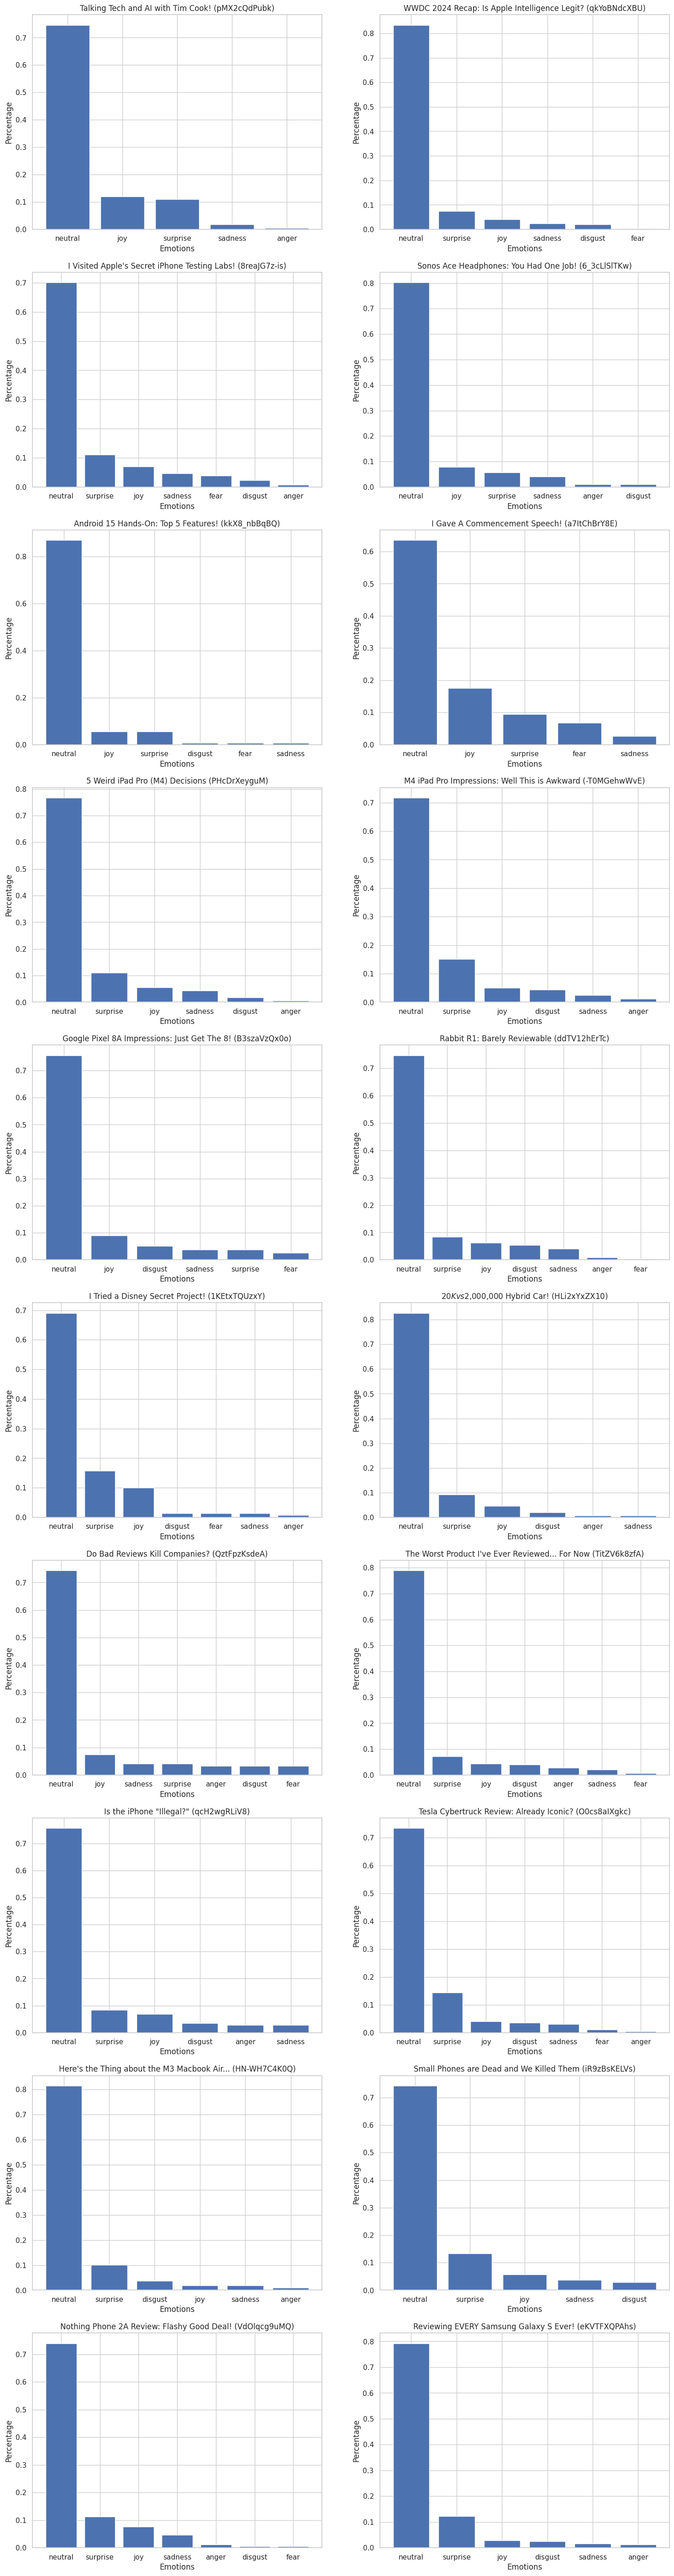

In [33]:
# List of lists to store the title and id of each video, the dominant emotion and the percentage of each emotion
video_graph_info_list = []

# Loop through the sentiment analysis results and store the information in the list
for video_graph_info in sentiment_video_df[['Video ID', 'Video Title']].drop_duplicates().values:
  video_graph_info = video_graph_info.tolist()
  temp_df = sentiment_video_df[sentiment_video_df['Video ID'] == video_graph_info[0]]
  temp_df = temp_df.value_counts('dominant').reset_index()
  temp_df['count'] = temp_df['count'] / temp_df['count'].sum()
  video_graph_info += [temp_df['dominant'].values.tolist()]
  video_graph_info += [temp_df['count'].values.tolist()]
  video_graph_info_list += [video_graph_info]

# Create a figure with subplots to display the dominant emotion and the percentage of each emotion for each video in a bar graph
figure, axis = plt.subplots(gridsVertical, gridsHorizontal)
figure.set_figwidth(18)
figure.set_figheight(72)

# Loop through the video graph information list and create a bar graph for each video
for i in range(gridsVertical):
  for j in range(gridsHorizontal):
    axis[i, j].bar(video_graph_info_list[i*gridsHorizontal+j][2], video_graph_info_list[i*gridsHorizontal+j][3])
    axis[i, j].set_title(f'{video_graph_info_list[i*gridsHorizontal+j][1]} ({video_graph_info_list[i*gridsHorizontal+j][0]})')
    axis[i, j].set_xlabel('Emotions')
    axis[i, j].set_ylabel('Percentage')

In [34]:
# Display the sentiment analysis results in a (prettier) table
sentiment_comment_df

,Channel Name,Channel ID,Video Title,Video ID,Comment ID,Text,dominant,anger,disgust,fear,joy,neutral,sadness,surprise
0,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,UgzEswXILrJDcnyEhD94AaABAg,Mentioning Ergonomics and Magic Mouse in the s...,disgust,0.139221,0.747846,0.026572,0.001308,0.034481,0.010504,0.040068
1,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,UgzEswXILrJDcnyEhD94AaABAg.A4aI05D0prbA4aIsDMpkWd,I literally loled at that moment,surprise,0.020953,0.003539,0.002772,0.325785,0.279870,0.010582,0.356499
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,UgzEswXILrJDcnyEhD94AaABAg.A4aI05D0prbA4aIyVyBXNd,He cant be serious,sadness,0.013863,0.016560,0.031869,0.006785,0.224922,0.652966,0.053035
3,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,UgzEswXILrJDcnyEhD94AaABAg.A4aI05D0prbA4aJTmLjhHx,Was thinking the same thing lmao,neutral,0.026599,0.025455,0.009798,0.038141,0.685879,0.058295,0.155833
4,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,UgzEswXILrJDcnyEhD94AaABAg.A4aI05D0prbA4aJU0gLtlc,Right,neutral,0.176078,0.189842,0.224493,0.013344,0.352769,0.036022,0.007454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31987,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,Ugy8vXl8WRIC3I1__Z54AaABAg,Samsung galaxy s9 is poop phone ever I am usi...,anger,0.324299,0.133299,0.123869,0.033992,0.145906,0.110869,0.127766
31988,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,Ugy5PiuR3gNzGF9bT-B4AaABAg,s20 is the ugliest galaxy ever,disgust,0.012497,0.895620,0.044921,0.003453,0.008803,0.029513,0.005192
31989,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,Ugy-oJIJHhRmSLNU9Qx4AaABAg,I own the worse Samsung Galaxy evers20fe,disgust,0.290032,0.658101,0.003708,0.001408,0.008112,0.037306,0.001333
31990,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,UgxLc6Cys37kt77CuZ54AaABAg,All S20FE users gather here,neutral,0.044797,0.022870,0.193046,0.027117,0.688100,0.010403,0.013667


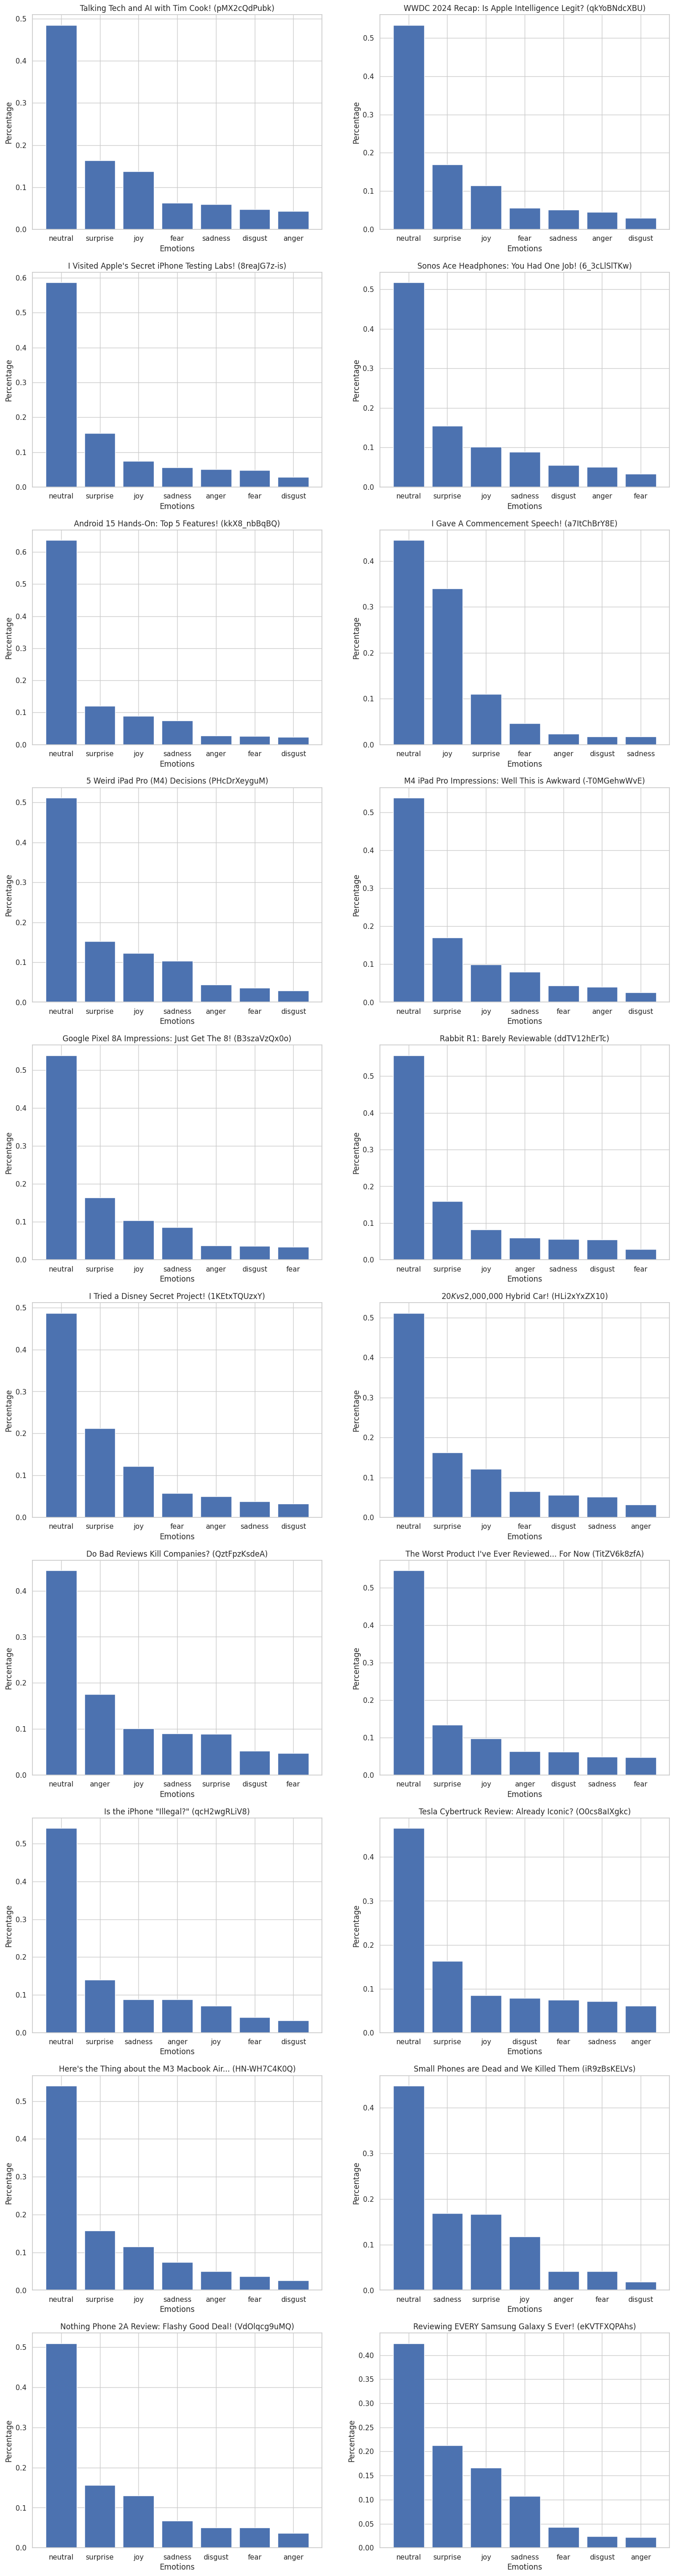

In [35]:
# List of lists to store the title and id of each video, the dominant emotion and the percentage of each emotion
comment_graph_info_list = []

# Loop through the sentiment analysis results and store the information in the list
for comment_graph_info in sentiment_comment_df[['Video ID', 'Video Title']].drop_duplicates().values:
  comment_graph_info = comment_graph_info.tolist()
  temp_df = sentiment_comment_df[sentiment_comment_df['Video ID'] == comment_graph_info[0]]
  temp_df = temp_df.value_counts('dominant').reset_index()
  temp_df['count'] = temp_df['count'] / temp_df['count'].sum()
  comment_graph_info += [temp_df['dominant'].values.tolist()]
  comment_graph_info += [temp_df['count'].values.tolist()]
  comment_graph_info_list += [comment_graph_info]

# Create a figure with subplots to display the dominant emotion and the percentage of each emotion for each video in a bar graph
figure, axis = plt.subplots(gridsVertical, gridsHorizontal)
figure.set_figwidth(18)
figure.set_figheight(72)

# Loop through the comment graph information list and create a bar graph for each video
for i in range(gridsVertical):
  for j in range(gridsHorizontal):
    axis[i, j].bar(comment_graph_info_list[i*gridsHorizontal+j][2], comment_graph_info_list[i*gridsHorizontal+j][3])
    axis[i, j].set_title(f'{comment_graph_info_list[i*gridsHorizontal+j][1]} ({comment_graph_info_list[i*gridsHorizontal+j][0]})')
    axis[i, j].set_xlabel('Emotions')
    axis[i, j].set_ylabel('Percentage')

### 6. Data Visualization


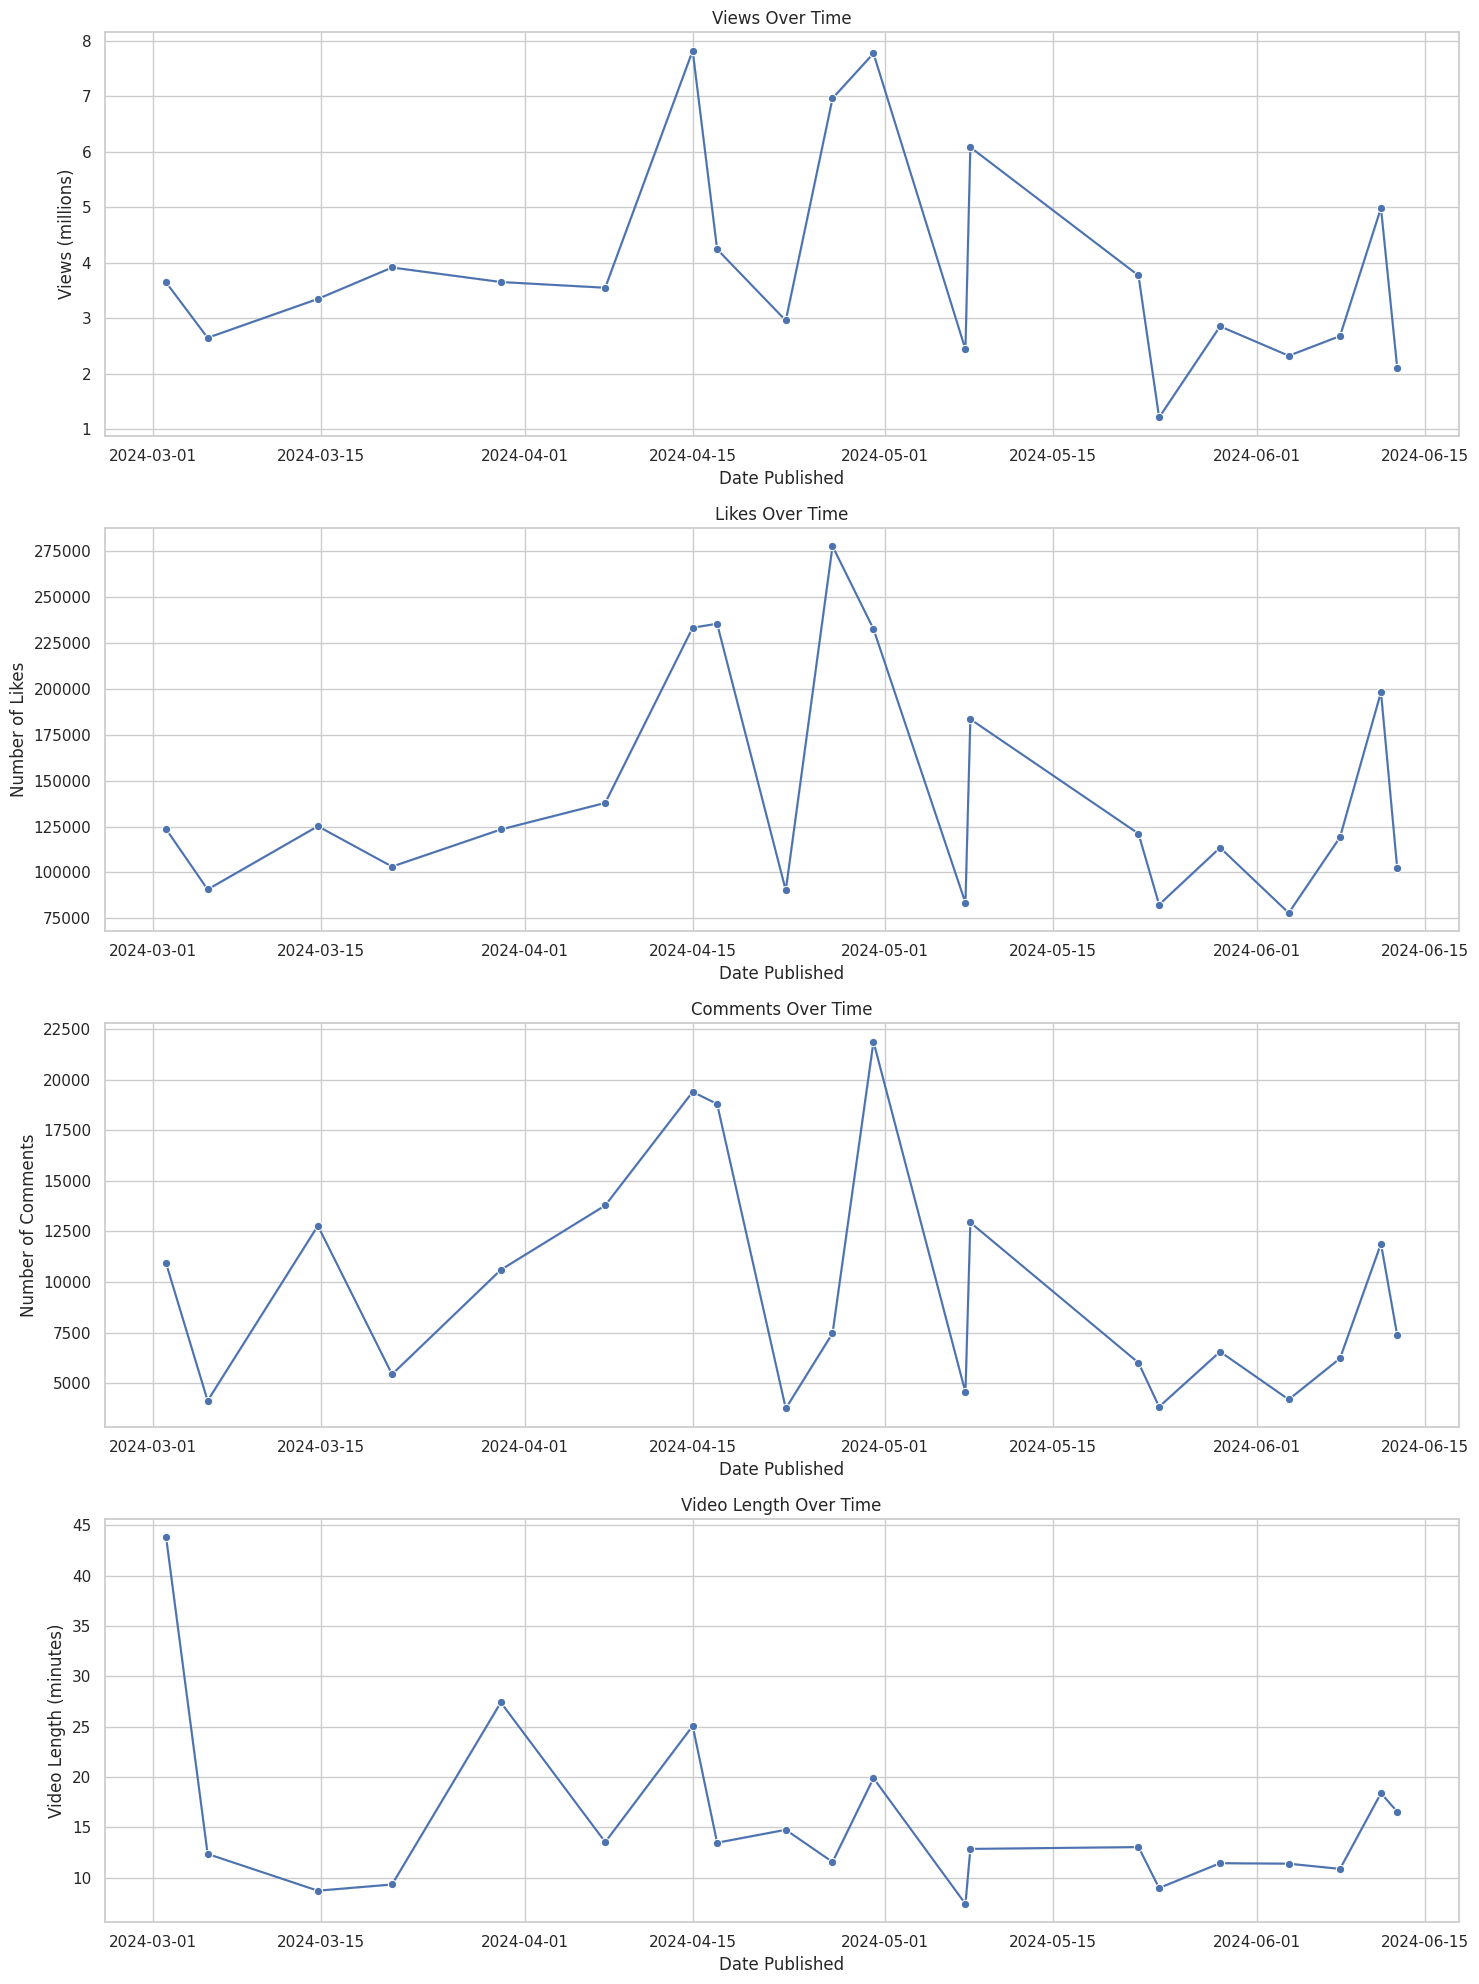

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import isodate

clean_video_df['Date Published'] = pd.to_datetime(clean_video_df['Date Published'])


# Function to convert duration string to total minutes
def convert_to_minutes(duration):
    if isinstance(duration, str):
        try:
            duration_obj = isodate.parse_duration(duration)
            total_seconds = duration_obj.total_seconds()
            total_minutes = total_seconds / 60
            return total_minutes
        except isodate.ISO8601Error:
            return 0
    elif isinstance(duration, pd.Timedelta):
        total_seconds = duration.total_seconds()
        total_minutes = total_seconds / 60
        return total_minutes
    else:
        return 0

# Apply the conversion function
clean_video_df['Video Length (minutes)'] = clean_video_df['Video Length'].apply(convert_to_minutes)

# Convert views to millions
clean_video_df['No. Views (millions)'] = clean_video_df['No. Views'] / 1_000_000

# Set the style for the plots
sns.set(style="whitegrid")

# Formatter to remove scientific notation
def plain_formatter(x, pos):
    return '%1.0f' % x

# Create subplots for each metric
fig, axes = plt.subplots(4, 1, figsize=(15, 20))

# Plotting Views
sns.lineplot(ax=axes[0], x='Date Published', y='No. Views (millions)', data=clean_video_df, marker='o')
axes[0].set_title('Views Over Time')
axes[0].set_ylabel('Views (millions)')

# Plotting Likes
sns.lineplot(ax=axes[1], x='Date Published', y='No. Likes', data=clean_video_df, marker='o')
axes[1].set_title('Likes Over Time')
axes[1].set_ylabel('Number of Likes')

# Plotting Comments
sns.lineplot(ax=axes[2], x='Date Published', y='No. Comments', data=clean_video_df, marker='o')
axes[2].set_title('Comments Over Time')
axes[2].set_ylabel('Number of Comments')

# Plotting Video Length
sns.lineplot(ax=axes[3], x='Date Published', y='Video Length (minutes)', data=clean_video_df, marker='o')
axes[3].set_title('Video Length Over Time')
axes[3].set_ylabel('Video Length (minutes)')
axes[3].set_xlabel('Date Published')
axes[3].yaxis.set_major_formatter(FuncFormatter(plain_formatter))

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
